In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in data

In [2]:
aneuploidy_events = pd.read_csv("/data/aneuploidy/aneuploidy_events.csv", index_col = 0)

In [3]:
print(aneuploidy_events.shape)

(204374, 198)


In [4]:
LOSS_FRAC = 0.7
MIN_GENES = 150

for chrom in ('chr%d' % i for i in range(1, 23)):
    
    left_binary = aneuploidy_events['%s_left_binary' % chrom]
    left_n = aneuploidy_events['%s_left_n' % chrom]
    right_binary = aneuploidy_events['%s_right_binary' % chrom]
    right_n = aneuploidy_events['%s_right_n' % chrom]
    total_binary = (left_n * left_binary + right_n * right_binary) / (left_n + right_n)
    
    lost_all = (total_binary <= 1 - LOSS_FRAC)
    lost_left = (left_binary <= 1 - LOSS_FRAC)
    lost_right = (right_binary <= 1 - LOSS_FRAC)
    lost_only_left = lost_left & (~lost_right)
    lost_only_right = lost_right & (~lost_left)
    enough_genes_left = (left_n >= MIN_GENES)
    enough_genes_right = (right_n >= MIN_GENES)
    lost_partial = (lost_only_left & enough_genes_left) | (lost_only_right & enough_genes_right)
    
    event = np.where(lost_partial, 'lost_partial', np.where(lost_all, 'lost_all', 'no_loss'))
    aneuploidy_events['%s_event' % chrom] = event

In [5]:
adata = sc.read_h5ad("qced.h5ad")

In [6]:
for i in range(1, 23):
    adata.obs["chr" + str(i) + "_event"] = aneuploidy_events["chr" + str(i) + "_event"]
for i in range(1, 23):
    adata.obs["chr" + str(i) + "_bp_loc"] = aneuploidy_events["chr" + str(i) + "_bp_loc"]

In [7]:
adata = adata[adata.obs['qc_pass'],:]

# Read in files with gene and centromere locations for plotting

In [8]:
gene_locs = pd.read_csv('/data/aneuploidy/inferCNVgeneName.txt', sep = '\t', names = ['gene', 'chrom', 'start', 'end'])
gene_to_chrom = gene_locs.set_index('gene')['chrom']

In [11]:
# Label cell with chromosome of guide
gene_to_chrom['Multiple Guides'] = np.nan
gene_to_chrom['Non'] = np.nan
adata.obs['target_chrom'] = adata.obs['guides'].apply(lambda x: gene_to_chrom[x.split("-")[0]])

/tmp/ipykernel_2085364/2742165795.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['target_chrom'] = adata.obs['guides'].apply(lambda x: gene_to_chrom[x.split("-")[0]])


In [14]:
chr_lengths = pd.read_csv("chr_lengths.csv", header = None, index_col = 0)

In [ ]:
centromeres = pd.read_csv("/data/aneuploidy/centromeres.txt", sep = "\t")
centromeres_proc = pd.DataFrame(np.zeros((len(set(centromeres['chrom'])),2)), index = list(set(centromeres['chrom'])), columns = ['start', 'end'])
for chrom in list(set(centromeres['chrom'])):
    centromeres_proc.loc[chrom, 'start'] = np.min(centromeres.loc[centromeres['chrom'] == chrom, "chromStart"])
    centromeres_proc.loc[chrom, 'end'] = np.max(centromeres.loc[centromeres['chrom'] == chrom, "chromEnd"])

# Make Figure S2F

In [ ]:
def get_loc(x):
    try:
        return gene_locs.loc[gene_locs['gene'] == x.split("-")[0],"start"].values[0]
    except IndexError:
        return np.nan

/tmp/ipykernel_2085364/2352233936.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = lost_partial.groupby('target_loc').mean()['chr' + str(i) + '_bp_loc']
/tmp/ipykernel_2085364/2352233936.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sds = 1.96*lost_partial.groupby('target_loc').std()['chr' + str(i) + '_bp_loc']/lost_partial['target_loc'].value_counts()
/tmp/ipykernel_2085364/2352233936.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns whi

/tmp/ipykernel_2085364/2352233936.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = lost_partial.groupby('target_loc').mean()['chr' + str(i) + '_bp_loc']
/tmp/ipykernel_2085364/2352233936.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sds = 1.96*lost_partial.groupby('target_loc').std()['chr' + str(i) + '_bp_loc']/lost_partial['target_loc'].value_counts()
/tmp/ipykernel_2085364/2352233936.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns whi

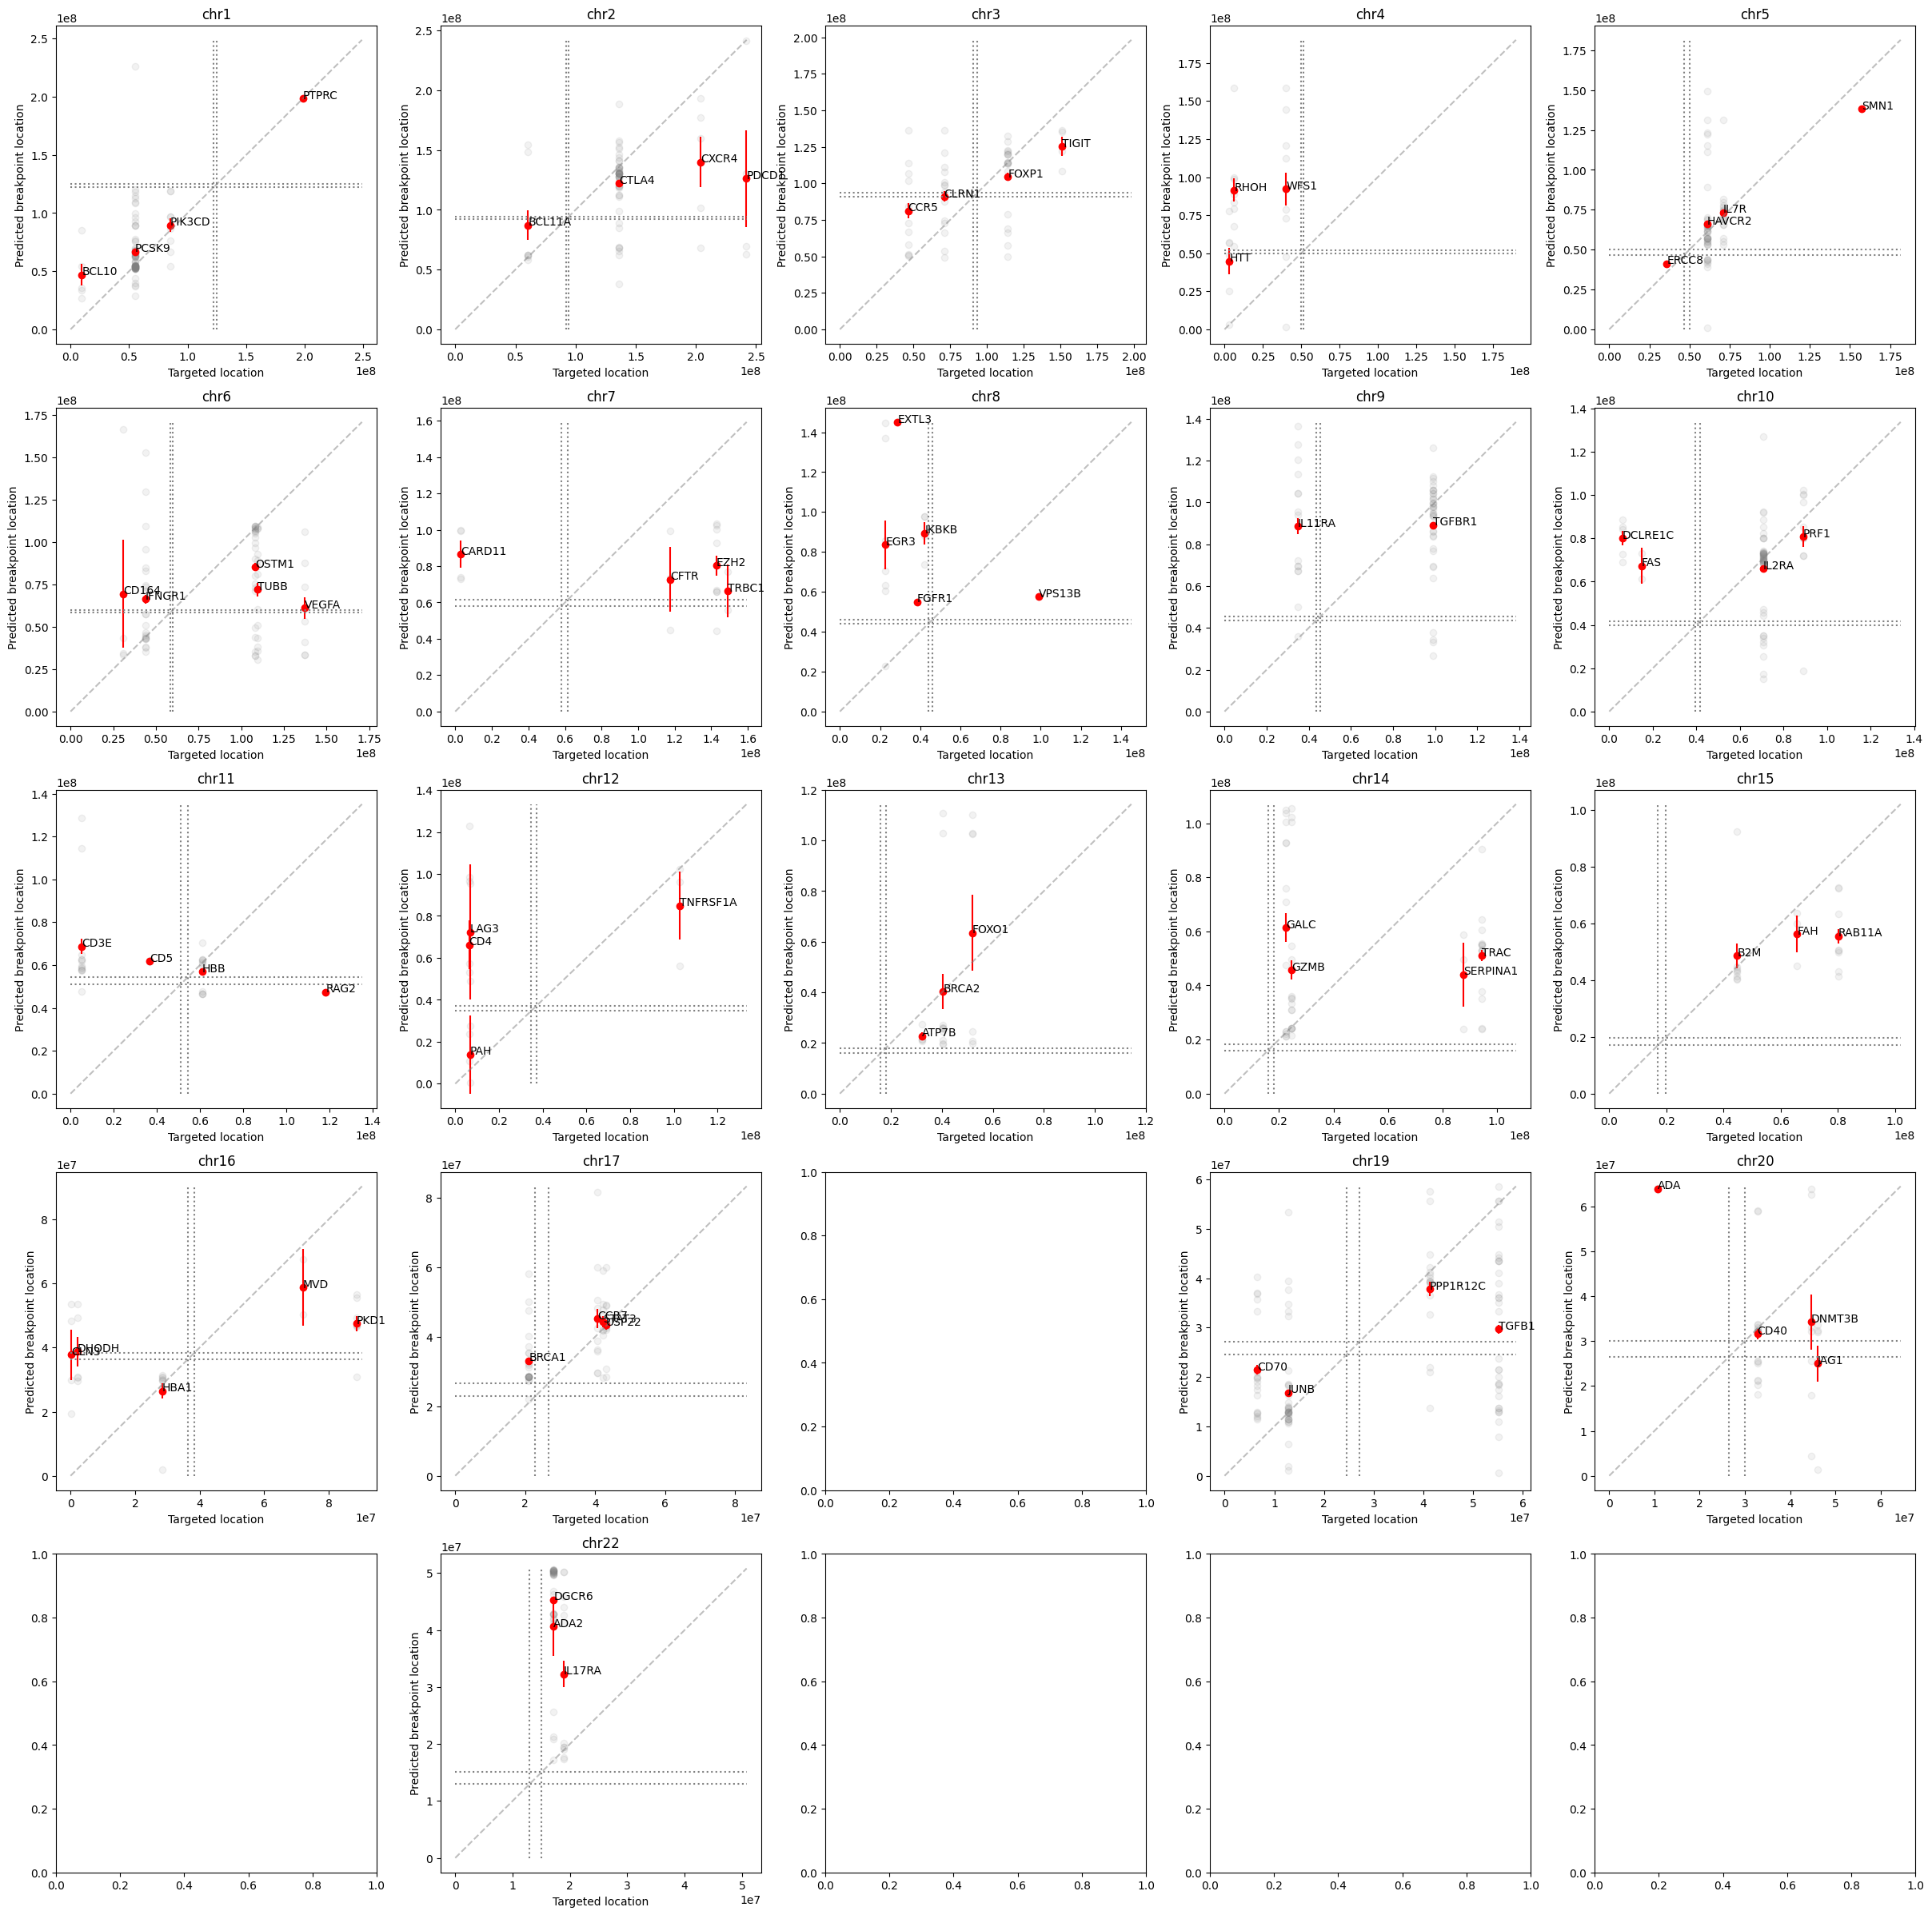

In [26]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (30,30))
for i in range(1,23):
    # find the lost_partial cells for this chromosome
    lost_partial = adata.obs.loc[adata.obs['chr' + str(i) + '_event'] == "lost_partial",:]
    if len(lost_partial) == 0:
        continue
    lost_partial = lost_partial.loc[lost_partial['target_chrom'] == "chr" + str(i),:]
    lost_partial['target_loc'] = lost_partial['guides'].apply(get_loc)
    
    # calculate means and sds
    genes = sorted(set(lost_partial['guides'].apply(lambda x: x.split("-")[0])))
    means = lost_partial.groupby('target_loc').mean()['chr' + str(i) + '_bp_loc']
    sds = 1.96*lost_partial.groupby('target_loc').std()['chr' + str(i) + '_bp_loc']/lost_partial['target_loc'].value_counts()
    
    # plot all breakpoint locations
    ax1 = ax[int((i-1)/5), int((i-1)%5)].scatter(lost_partial['target_loc'],
                                                 lost_partial['chr' + str(i) + '_bp_loc'], 
                                                 color = 'grey', label = 'lost_partial', alpha = 0.1)
    
    # plot means
    ax[int((i-1)/5), int((i-1)%5)].scatter(means.index,
                                           means.values, c = 'r')
    ax[int((i-1)/5), int((i-1)%5)].errorbar(means.index,
                                           means.values, yerr = sds, linestyle='none', c = 'r')
    
    # write gene name
    for j, gene in enumerate(genes):
        ax[int((i-1)/5), int((i-1)%5)].annotate(gene, (means.index[j], means.values[j]))
    
    # plot centromere locations, diagonal line, labels
    ax[int((i-1)/5), int((i-1)%5)].set_title("chr" + str(i))
    ax[int((i-1)/5), int((i-1)%5)].set_xlabel("Targeted location")
    ax[int((i-1)/5), int((i-1)%5)].set_ylabel("Predicted breakpoint location")
    ymin = 0
    xmin = 0
    ymax = int(chr_lengths.loc[str(i), 1].replace(",",""))
    xmax = ymax
    ax[int((i-1)/5), int((i-1)%5)].plot((xmin,xmax), (ymin,ymax), color = 'gray', alpha = 0.5, linestyle='--')
    ax[int((i-1)/5), int((i-1)%5)].vlines(x = centromeres_proc.loc[("chr" + str(i)), "start"], ymin = ymin, ymax = ymax, color = "gray", ls = ':')
    ax[int((i-1)/5), int((i-1)%5)].vlines(x = centromeres_proc.loc[("chr" + str(i)), "end"], ymin = ymin, ymax = ymax, color = "gray", ls = ':')
    ax[int((i-1)/5), int((i-1)%5)].hlines(y = centromeres_proc.loc[("chr" + str(i)), "start"], xmin = ymin, xmax = ymax, color = "gray", ls = ':')
    ax[int((i-1)/5), int((i-1)%5)].hlines(y = centromeres_proc.loc[("chr" + str(i)), "end"], xmin = ymin, xmax = ymax, color = "gray", ls = ':')

    
plt.savefig("breakpoint_scatter.pdf")